In [98]:
import json
import pandas as pd

response = open('transaction-data-adhoc-analysis.json')
data = json.load(response)
df = pd.DataFrame(data)

#Returns the month name of transaction date
def monthlist(date):
    monthsonly = date.split("/")[1]
    if "1" in monthsonly:
        return('January')
    elif "2" in monthsonly:
        return('February')
    elif "3" in monthsonly:
        return('March')
    elif "4" in monthsonly:
        return('April')
    elif "5" in monthsonly:
        return('May')
    elif "6" in monthsonly:
        return('June')

#Returns a series of the month name of each transaction date
nmonthlist = pd.Series(monthlist(i) for i in list(df['transaction_date']))

#Adds a column named 'month' in original df which displays the month name of each transaction date
df.insert(0, 'month', nmonthlist, allow_duplicates = False)

#Month list
months = list(df['month'].drop_duplicates())

#Returns number of specific products sold per month
def transacitemspm(month):
    monthlydf = df[df["month"]==month]
    blank = []
    for i in monthlydf['transaction_items']:
        x = i.split(";")
        for i in range(0,len(x)):
            blank.append(x[i].split(','))
    productdfpm = pd.DataFrame(blank, columns=('Brandname','Productname','Quantity'))
    numseparated = productdfpm['Quantity'].str.extract(r'([(x)])(\d)',expand=False)
    productdfpm['Quantity'] = numseparated.drop(columns=0)
    productdfpm['Quantity'] = productdfpm['Quantity'].astype(int)
    itemssoldpermonth=productdfpm.groupby('Productname').sum().squeeze()
    return itemssoldpermonth

#Returns table displaying products sold per month (First table)
salesquanspec_df = pd.DataFrame({i:transacitemspm(i) for i in months})

#Pricelist returns unedited price list (with Brand and Quantity)
ptlist= df[["transaction_items","transaction_value"]].drop_duplicates(subset=['transaction_items'])
pricelist=ptlist.loc[(df['transaction_items'].str.contains(";") == False) & (df['transaction_items'].str.contains("x1"))]

#Jitems returns official price list
chart = []
for i in range(0, len(list(pricelist["transaction_items"]))):
    chart.append(list(pricelist["transaction_items"])[i].split(','))
items = pd.DataFrame(chart, columns=['Brand', 'Product', 'Quantity'])
jitems = items.drop(columns = ['Quantity', 'Brand'])
cost = pricelist.drop(columns=['transaction_items'])
jitems.insert(1, 'Value', cost, allow_duplicates = False)

#Returns price per product
def pprice(item):
    pjitems = jitems['Product']
    for i in pjitems:
        if i == item:
            pnv = (jitems.loc[jitems['Product']==i])
            prodval = int(pnv['Value'])
            return prodval
                
#Returns sales value per item per months
def tsvpmonth(item):      
    return(salesquanspec_df.loc[item]*pprice(item))
salesval_df = pd.DataFrame({i:tsvpmonth(i) for i in list(jitems['Product'])})

#Returns table of sale value per item per month (Second Table)
finalsalesval_df = salesval_df.transpose() 

#Returns transaction data of customers per month without name duplicates
def custpermonth(month):
    mcust = df[df["month"]==month].drop_duplicates(subset=['name'])
    return mcust

#Returns dictionary of customers per month
acustdict = {i:custpermonth(i) for i in months}

#Returns just the names of the customers per month
def monthlycustomers(month):
    mcust = set(df[df["month"]==month].drop_duplicates(subset=['name'])['name'])
    return mcust

#Returns dictionary of set customers per month
bcustdict = {i:monthlycustomers(i) for i in months}

#Returns the number of repeaters per specific month
def repeater(month):
    if month == 'January':
        return 0
    else:
        monthnum = months.index(month)
        pastmonth = months[monthnum-1]
        monthspecified = pd.Series(acustdict[month]['name'])
        monthago = pd.Series(acustdict[pastmonth]['name'])
        merged = pd.merge(monthspecified, monthago, how ='inner')
        return len(merged)  

#Returns the number of inactive customers per specific month
def inactive(month):
    if month == 'January':
        return 0
    else:
        monthnum = months.index(month)
        pastmonth = months[:monthnum]
        monthspecified = pd.Series(acustdict[month]['name'])
        monthago = df[df["month"].isin(pastmonth)].drop_duplicates(subset=['name'])
        merged = pd.merge(monthspecified, monthago, how ='inner')
        return len(monthago) - len(merged)

#Returns the number of engaged customers per specific month
def engaged(month):
    monthnum = months.index(month)
    jancust = set(bcustdict[months[0]])
    i = 0
    while i <= monthnum:
        currlist = set(bcustdict[months[i]])
        custs = jancust & currlist
        i = i+1
        if i > monthnum:
            return len(custs)
        
#Returns number of repeaters per each month from January to June
repeater_s = pd.Series({i:repeater(i) for i in months})

#Returns number of inactive customers per each month from January to June
inactive_s = pd.Series({i:inactive(i) for i in months})

#Returns number of engaged customers per each month from January to June
engaged_s = pd.Series({i:engaged(i) for i in months})

blanklist = []
#Returns table displaying repeaters, inactive, and engaged per month (Third Table)
metric_df = pd.DataFrame({'Repeaters':repeater_s,'Inactive':inactive_s,'Engaged':engaged_s}).transpose()

#Other codes:
#Returns sales value per item per specific month
def spipmonth(item, month):
        for i in final_df:
            if month in i:
                fmonth = final_df[month]
                sfmonth = fmonth[item]
                def pprice(item):
                    pjitems = jitems['Product']
                    for i in pjitems:
                        if i == item:
                            pnv = (jitems.loc[jitems['Product']==i])
                            prodval = int(pnv['Value'])
                            return prodval
                return(sfmonth*pprice(item))
            
#Returns the transaction months of a specific name
def userpurchases(name):
    unameindex = df[df['name'] == name].index
    uname_df = df.iloc[unameindex]
    return uname_df[["month","name"]]

#Returns the names of all customers
custlist = df['name'].drop_duplicates()


In [99]:
#First table
salesquanspec_df

,January,February,March,April,May,June
Productname,,,,,,
Beef Chicharon,9665,10001,9816,9890,10028,9902
Gummy Vitamins,9681,9980,10145,9842,9948,9980
Gummy Worms,9559,9996,9986,10043,9801,9934
Kimchi and Seaweed,9676,9949,9967,9921,9773,10104
Nutrional Milk,9727,9691,9876,9786,9881,9767
Orange Beans,9774,10037,9611,9914,9964,10106
Yummy Vegetables,9959,10256,9896,9861,9735,9722


In [100]:
#Second Table
finalsalesval_df

,January,February,March,April,May,June
Yummy Vegetables,4979500,5128000,4948000,4930500,4867500,4861000
Gummy Worms,1433850,1499400,1497900,1506450,1470150,1490100
Beef Chicharon,12554835,12991299,12750984,12847110,13026372,12862698
Kimchi and Seaweed,7731124,7949251,7963633,7926879,7808627,8073096
Orange Beans,1945026,1997363,1912589,1972886,1982836,2011094
Gummy Vitamins,14521500,14970000,15217500,14763000,14922000,14970000
Nutrional Milk,19356730,19285090,19653240,19474140,19663190,19436330


In [101]:
#Third Table
metric_df

,January,February,March,April,May,June
Repeaters,0,5172,5216,5154,5110,5193
Inactive,0,1416,1747,1909,1917,1835
Engaged,6588,5172,5210,5151,5143,5195


<AxesSubplot:>

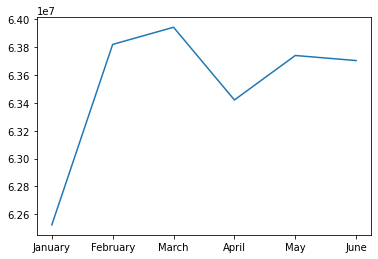

In [102]:
#Returns Line Graph of Total Sale Value per Month from January to June
totsales = salesval_df.sum(axis=1)
totsales.plot.line(x='Months',y='Sales')

<AxesSubplot:>

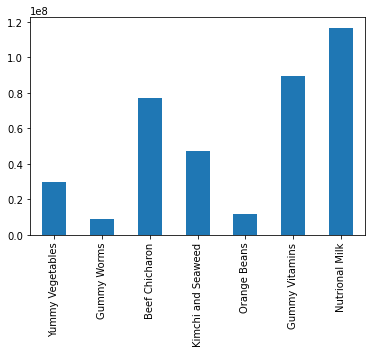

In [103]:
#Returns Bar Graph of Total Sale Value per Item from January to June
itemsales = finalsalesval_df.sum(axis=1)
itemsales.plot.bar(x='Products',y='Sales')

<AxesSubplot:>

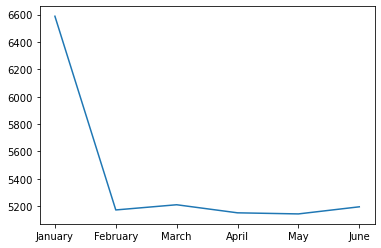

In [104]:
#Returns line graph of engaged customers from January to June
nmetric_df = metric_df.transpose()
nmetric_df['Engaged'].plot.line(x='Month',y='No. of Repeaters')

<AxesSubplot:>

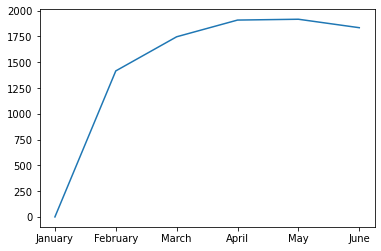

In [105]:
#Returns line graph of inactive customers from January to June
nmetric_df['Inactive'].plot.line(x='Month',y='No. of Repeaters')

<AxesSubplot:>

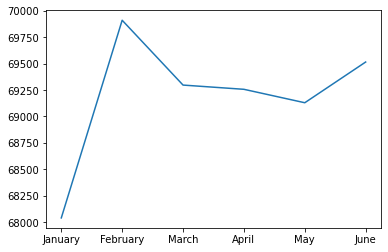

In [107]:
#Returns the total number of products sold from January to June
nsalesquanspec_df=salesquanspec_df.transpose()
productssoldm = nsalesquanspec_df.sum(axis=1)
productssold.plot.line(x='Months',y='No. of Products')

<AxesSubplot:xlabel='Productname'>

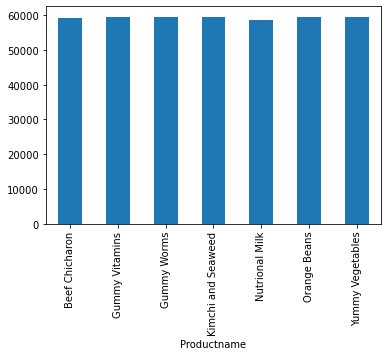

In [110]:
productssoldp = salesquanspec_df.sum(axis=1)
productssoldp.plot.bar(x='Products',y='No. of Products')